# Taller 2. Análisis de interacción genotipo por ambiente
Genética de rasgos complejos 2024-01 - Docente Johana Carolina Soto Sedano

__Hans D. Escobar H.__

In [37]:
# GGEBiplots has some issue with ggplot
options(warn = -1)

missing_packages <- character()
for (package in c(
  "GGEBiplots"
)) {
  if (!require(package, quietly = TRUE, character.only = TRUE)) {
    missing_packages <- append(missing_packages, package)
  }
}

if (length(missing_packages) > 0) {
  stop(
    sprintf(
      "Missing the following packages: %s",
      paste(missing_packages, collapse = ", ")
    ),
    call. = FALSE
  )
}


In [38]:
df <- read.delim(
  "Private_Data/cassava2.txt",
  row.names = 1
)
cat("Genotipos: ", nrow(df), "\n")
cat("Ambientes:
  \t- e1: Arauca
  \t- e2: La Vega
  \t- e3: Invernadero")


Genotipos:  100 
Ambientes:
  	- e1: Arauca
  	- e2: La Vega
  	- e3: Invernadero

In [39]:
head(df)


,e1,e2,e3
,<dbl>,<dbl>,<dbl>
g1,1.36,1.29,1.41
g2,1.39,1.15,1.37
g3,1.34,0.97,1.48
g4,1.38,1.29,1.61
g5,1.61,1.15,1.30
g6,1.48,1.35,1.63


## 1. Modelo genotipo + genotipo x ambiente  PCA

The vector view of the GGE biplot:

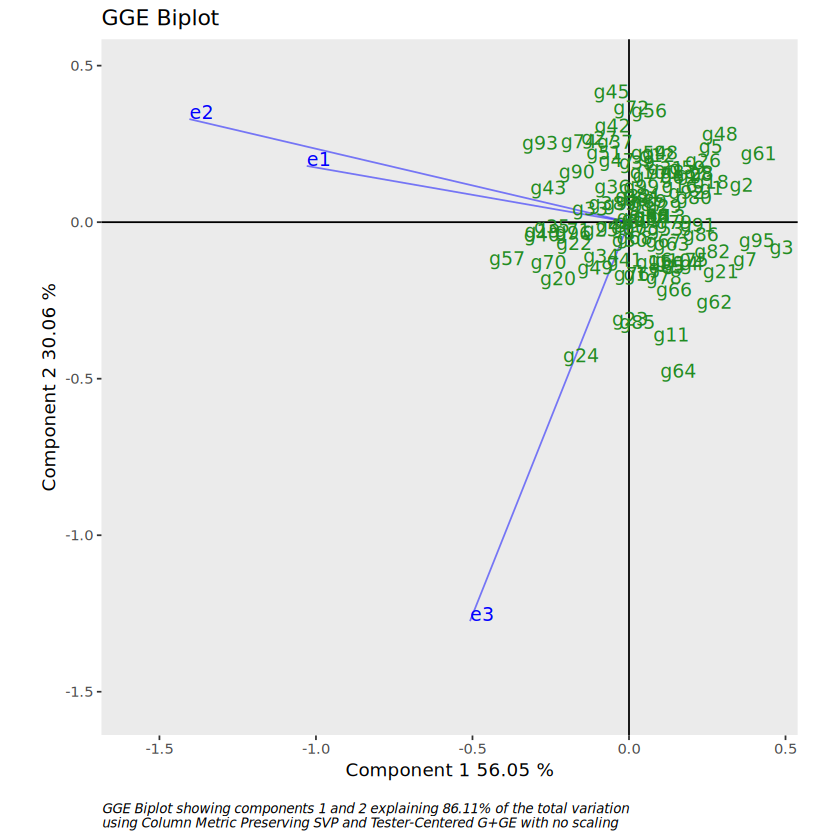

In [40]:
gge_model <- GGEModel(df)
GGEPlot(gge_model)


- __¿El comportamiento de los genotipos es más similar en qué ambientes?__
En Arauca (e1) y La Vega (e2) se presenta el comportamiento más similar. Los ángulos entre e1 y e2 son pequeños, mostrando fuerte correlación positiva (__cos__(angulo) ≈ coeficiente de correlación (Yan, 2019)); en contraste, Invernadero (e3) tiene correlación cercana a cero con e1 y e2.

## 2. Compare el comportamiento de dos genotipos entre los ambientes

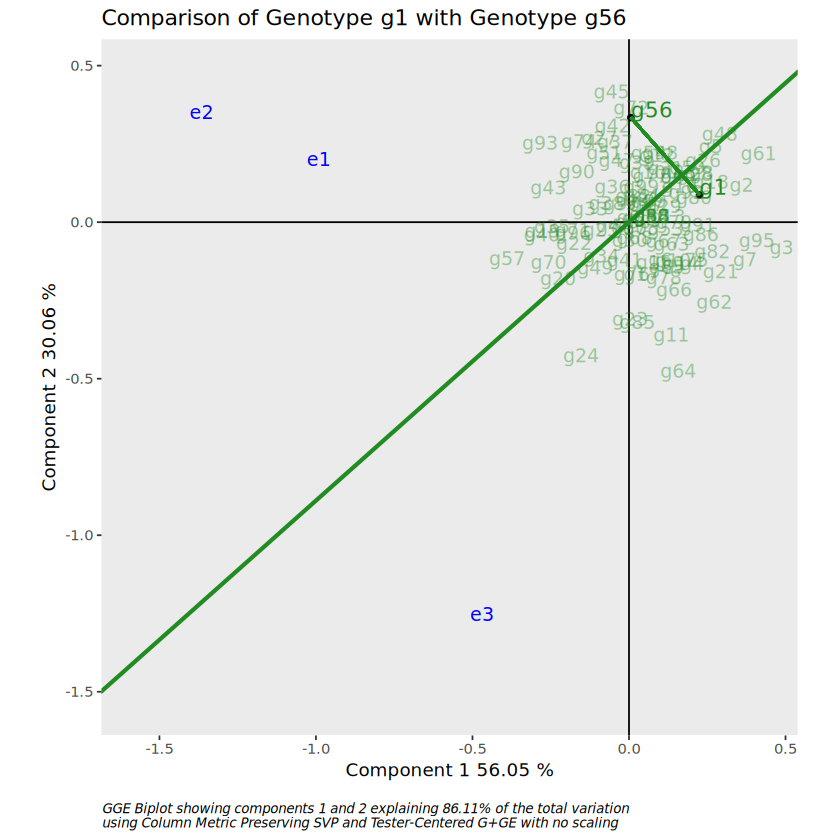

In [41]:
CompareGens(gge_model, G1 = "g1", G2 = "g56")

# No estoy seguro el significado del warning, pero también aparece
# con los datos de ejemplo del paquete, por lo que es un problema de
# como este hace uso de ggplot.
# Issue relacionado: https://github.com/tidyverse/ggplot2/issues/5762


- El genotipo g56 se desempeña mejor que g1 en Arauca (e1) y La Vega (e2). En invernadero (e3), g1 supera a g56.

## 3. Discrimination vs. representativeness biplot

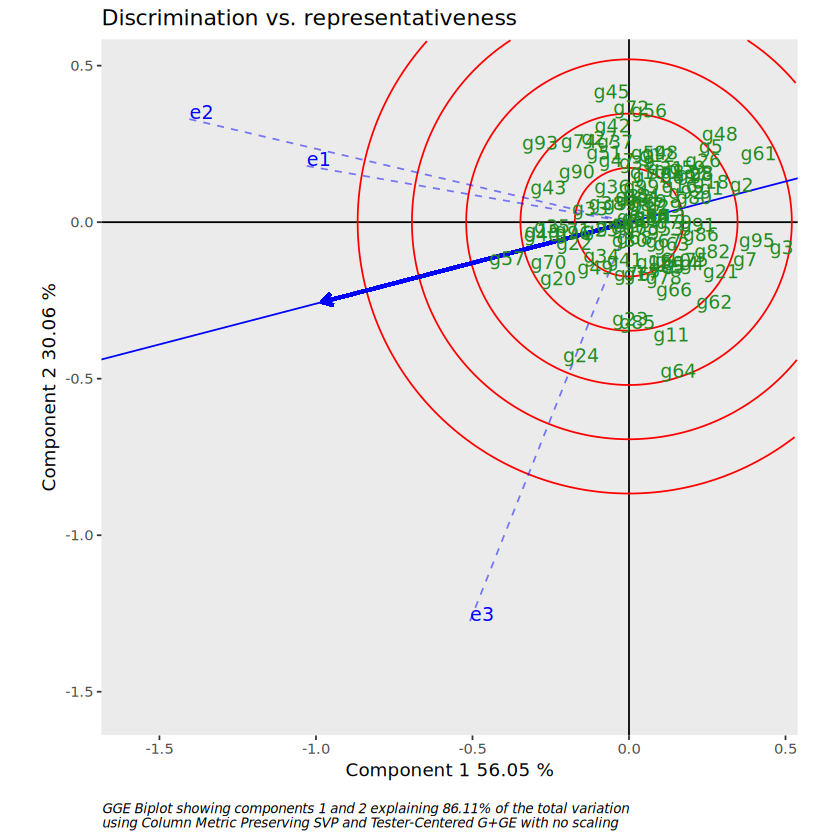

In [42]:
DiscRep(gge_model)


In [49]:
# Discrimination ability

vector_length <- function(row, components = 2) {
  sqrt(crossprod(row[1:components]))
}

capacidad_discriminante <- apply(
  gge_model$coordenviroment,
  MARGIN = 1, vector_length
)

# Representativeness ability

obtener_angulo <- function(vector1, vector2) {
  # A · B = |A| |B| cos(θ)
  norma1 <- sqrt(crossprod(vector1))
  norma2 <- sqrt(crossprod(vector2))
  acos(crossprod(vector1, vector2) / (norma1 * norma2))
}

average_environment_coordinate <- apply(
  gge_model$coordenviroment[, 1:2],
  MARGIN = 2, mean
)

representatividad <- apply(
  gge_model$coordenviroment[, 1:2],
  MARGIN = 1, obtener_angulo, vector2 = average_environment_coordinate
)

# summary

data.frame(
  capacidad_discriminante, representatividad,
  row.names = gge_model$labelenv
)


,capacidad_discriminante,representatividad
,<dbl>,<dbl>
e1,1.044955,0.4273446
e2,1.442443,0.4848585
e3,1.371863,0.9369504


- La longitud de vector se aproxima a la desviación estándar del ambiente, la cual es una medida de la capacidad discriminante del ambiente (Yan, 2019). En estos datos:

  - La Vega (e2) tiene la mayor capacidad discriminante, seguida estrechamente por el Invernadero (e3).
  - Arauca (e1) es el vector mas corto; por lo tanto, en este ambiente los genotipos son mas similares.

- El angulo entre el vector de un ambiente y el eje AEC (_average environment coordinate_) es una medida de la representatividad del ambiente (Yan, 2019). En estos datos, Arauca (e1) seguido por La Vega (e2) son los mas representativos.

- La Vega (e2) es discriminante y representativo, por lo que es un ambiente de prueba adecuado.

## 4. relaciones entre ambientes

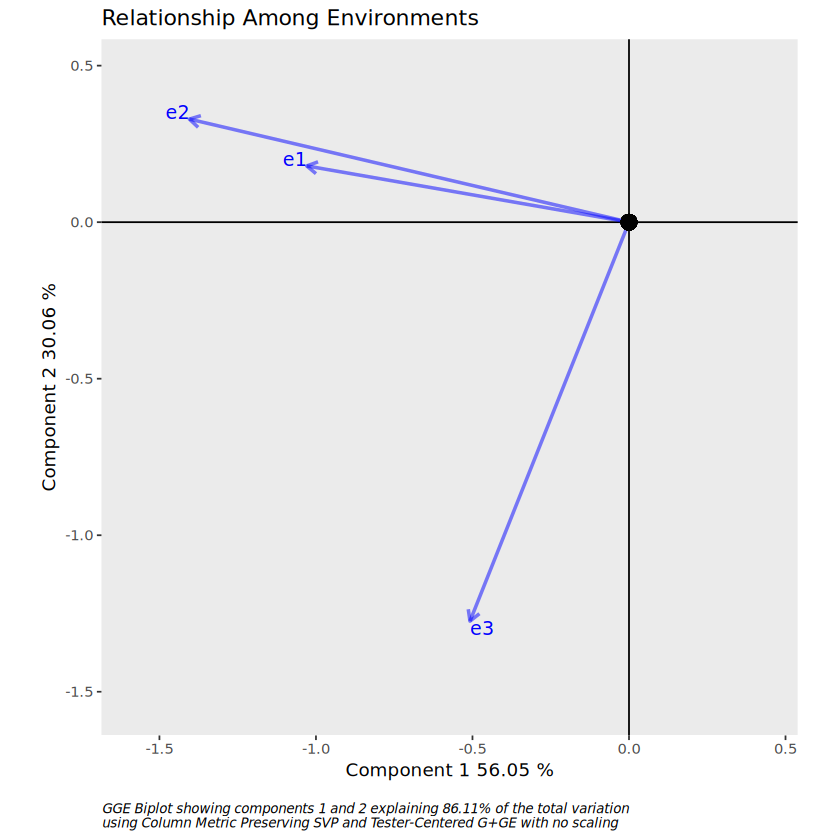

In [50]:
EnvRelationship(gge_model)


- Como se indico en el punto 1, Arauca (e1) y La Vega (e2) son los mas similares. 

## 5. Mean vs stability

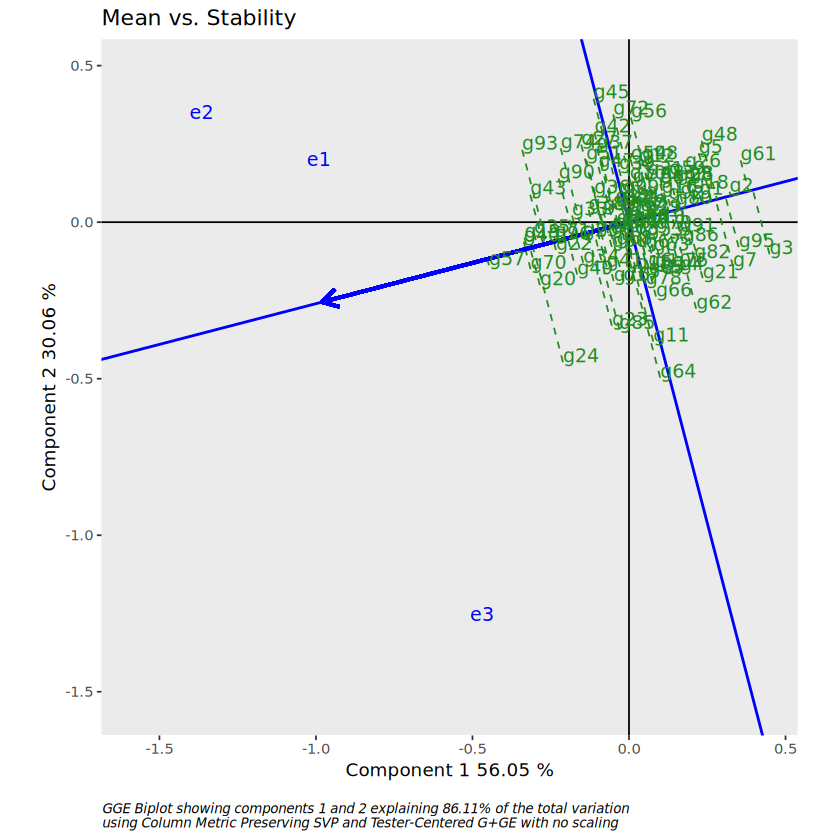

In [51]:
MeanStability(gge_model)


In [191]:
get_orthonormal <- function(componente1, componente2) {
  ortogonal <- c(1, -componente1 / componente2)
  ortogonal / sqrt(crossprod(ortogonal))
}

aec_ordinate <- get_orthonormal(
  average_environment_coordinate[1], average_environment_coordinate[2]
)
transformation_matrix <- matrix(
  c(average_environment_coordinate, aec_ordinate), 2, 2
)

genotype_in_aec_basis <- t(apply(
  gge_model$coordgenotype[, 1:2],
  MARGIN = 1, (function(v) v %*% transformation_matrix)
))

genotype_aec_distance <- apply(
  genotype_in_aec_basis,
  MARGIN = 1, (function(v) sqrt(crossprod(v - c(1, 0))))
)

media_estabilidad <- data.frame(
  distancia_al_G_ideal = abs(genotype_in_aec_basis[, 1] - 1.02661),
  inestabilidad = abs(
    genotype_in_aec_basis[, 2]
  ),
  ambos = genotype_aec_distance,
  row.names = gge_model$labelgen
)

cat("Top mejores por media y estabilidad: ")
head(
  media_estabilidad[
    order(media_estabilidad$ambos),
  ],
  n = 3
)

cat("Top mejores por SOLO estabilidad: ")
head(
  media_estabilidad[
    order(media_estabilidad$inestabilidad),
  ],
  n = 3
)

cat("Top peores por media y estabilidad: ")
head(
  media_estabilidad[
    order(media_estabilidad$ambos, decreasing = TRUE),
  ],
  n = 3
)

cat("Top peores por SOLO estabilidad: ")
head(
  media_estabilidad[
    order(media_estabilidad$inestabilidad, decreasing = TRUE),
  ],
  n = 3
)


Top mejores por media y estabilidad: 

,distancia_al_G_ideal,inestabilidad,ambos
,<dbl>,<dbl>,<dbl>
g57,0.5527001,0.02069339,0.5264970
g40,0.6810297,0.02469779,0.6548856
g70,0.6800396,0.06593768,0.6567481


Top mejores por SOLO estabilidad: 

,distancia_al_G_ideal,inestabilidad,ambos
,<dbl>,<dbl>,<dbl>
g55,1.0007558,0.004488108,0.9741561
g9,0.9864986,0.004513281,0.9598992
g96,0.7803856,0.005321186,0.7537944


Top peores por media y estabilidad: 

,distancia_al_G_ideal,inestabilidad,ambos
,<dbl>,<dbl>,<dbl>
g3,1.440687,0.21249495,1.429954
g61,1.426637,0.10131204,1.403688
g2,1.366409,0.01310105,1.339863


Top peores por SOLO estabilidad: 

,distancia_al_G_ideal,inestabilidad,ambos
,<dbl>,<dbl>,<dbl>
g64,0.9975977,0.5057943,1.094826
g45,1.0164065,0.4106025,1.071584
g11,1.0052384,0.3887607,1.053019


In [192]:
average_environment_coordinate %*% transformation_matrix


1.02661,0


In [218]:
cat(
  "Datos de los primeros valores de los top.
  Orden por estabilidad de mayor a menor"
)
df[c("g55", "g57", "g3", "g64"), ]


Datos de los primeros valores de los top.
  Orden por estabilidad de mayor a menor

,e1,e2,e3
,<dbl>,<dbl>,<dbl>
g55,1.47,1.50,1.56
g57,1.78,1.78,1.78
g3,1.34,0.97,1.48
g64,1.32,1.32,1.89


La proyección de los genotipos sobre el eje AEC es informativo de sus efectos medios, y la proyección sobre la perpendicular al eje AEC habla sobre su estabilidad. A menor distancia de la coordenada AEC, mayores efectos medios y mayor estabilidad.


## 6. Ranking environments and genotypes

## 7. “Which Won where/what”

## Bibliografía

- Dumble, S. (2022). GGEBiplots: GGE Biplots with “ggplot2” (v0.1.3) [R]. https://CRAN.R-project.org/package=GGEBiplots

- Yan, W. (2019). GGE BIPLOT ANALYSIS: A graphical tool for breeders, geneticists, and agronomists. CRC PRESS.
